In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import Lasso, SGDRegressor, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
sns.set()

Загрузка данных первого сета.

In [2]:
red_wine_data = pd.read_csv('winequality-red.csv', delimiter=';')
white_wine_data = pd.read_csv('winequality-white.csv', delimiter=';')
wines = pd.concat([red_wine_data,white_wine_data])

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [3]:
wines.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.7,0.600,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.60,12.9,6
96,6.8,0.775,0.00,3.0,0.102,8.0,23.0,0.9965,3.45,0.56,10.7,5
97,7.0,0.500,0.25,2.0,0.070,3.0,22.0,0.9963,3.25,0.63,9.2,5
98,7.6,0.900,0.06,2.5,0.079,5.0,10.0,0.9967,3.39,0.56,9.8,5


Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [4]:
wines.count()

fixed acidity           6497
volatile acidity        6497
citric acid             6497
residual sugar          6497
chlorides               6497
free sulfur dioxide     6497
total sulfur dioxide    6497
density                 6497
pH                      6497
sulphates               6497
alcohol                 6497
quality                 6497
dtype: int64

В процентном соотношении.

In [5]:
for col in wines.columns:
    pct_missing = np.mean(wines[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {wines[col].min()}     max:{wines[col].max()}')

fixed acidity - 0.0     min: 3.8     max:15.9
volatile acidity - 0.0     min: 0.08     max:1.58
citric acid - 0.0     min: 0.0     max:1.66
residual sugar - 0.0     min: 0.6     max:65.8
chlorides - 0.0     min: 0.009     max:0.611
free sulfur dioxide - 0.0     min: 1.0     max:289.0
total sulfur dioxide - 0.0     min: 6.0     max:440.0
density - 0.0     min: 0.98711     max:1.03898
pH - 0.0     min: 2.72     max:4.01
sulphates - 0.0     min: 0.22     max:2.0
alcohol - 0.0     min: 8.0     max:14.9
quality - 0.0     min: 3     max:9


Пропущенных значений нет, как и заявлялось в описании. Странность есть в минимальном значении столбца "chlorides", исправим:

In [6]:
wines["chlorides"] = round(wines["chlorides"], 3)

In [7]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Из таблицы резко выбиваются значения "free sulfur dioxide":289 и "total sulfur dioxide": 400. Проверим не ошибочные ли это данные.

<AxesSubplot: >

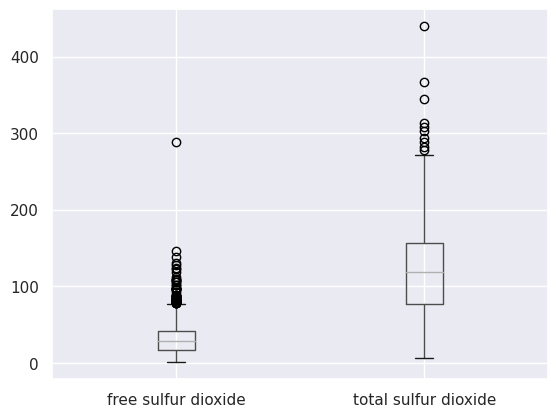

In [8]:
wines.boxplot(column=["free sulfur dioxide", "total sulfur dioxide"])

Можно предположить что значение столбца "free sulfur dioxide" значением около 300 может быть ошибочным, как и значение "total sulfur dioxide" более 400. Посмотрим на эти записи ближе.

In [9]:
wines[wines["free sulfur dioxide"] > 200]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4745,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


Как видно это оказывается одна запись. И хоть это и выбросы  но их объяснение просто: сверх высокая кислотность привод к минимальной оценке. Эти данные не являются ошибочными.

In [10]:
corr_matrix = wines.corr()
sns.heatmap(corr_matrix);

На таблицах корреляции, видно интересную картину, во первых корреляция присутствует в столбцах отвечающих за "кислость" вина, в принципе это не удивительно, чем больше сахара тем меньше кислости, и наоборот. Но есть один параметр напрямую коррелирующий с оценкой от экспертов, этот столбец "alcohol".

Т.к "free sulfur dioxide share" входи в "total sulfur dioxide share", "volatile acidity" в "fixed acidity", "citric acid" в "fixed acidity" уберём их корреляцию путём удаления коррелирующих параметров.

In [11]:
wines.drop(columns=["free sulfur dioxide","volatile acidity","citric acid","density","residual sugar"],inplace=True)

In [12]:
corr_matrix = wines.corr()
sns.heatmap(corr_matrix);

Применим самый простой скалер Min-max.

In [13]:
scaler = preprocessing.MinMaxScaler()

target = wines["quality"]
wines.drop(columns=["quality"],inplace=True)

columns = wines.columns
wines[columns] = scaler.fit_transform(wines[columns])

Разделим наш датасет на 3 составляющие тренировочную, валидационную и тестовую.

In [14]:
datasets= {"train":{},"validation":{},"test":{}}
datasets["train"]["data"], test_val_data, datasets["train"]["target"], test_val_target = train_test_split(wines, target, train_size=0.769585962753, shuffle=True)
datasets["test"]["data"], datasets["validation"]["data"], datasets["test"]["target"], datasets["validation"]["target"] = train_test_split(test_val_data, test_val_target, test_size=0.668002672011, shuffle=True)

Предоставим нашим 4 моделям тестовые данные, пусть работают.

In [15]:
sgd = SGDRegressor()
sgd.fit(datasets["train"]["data"],datasets["train"]["target"])
lasso = Lasso()
lasso.fit(datasets["train"]["data"],datasets["train"]["target"])
ridge = Ridge()
ridge.fit(datasets["train"]["data"],datasets["train"]["target"])
linear = LinearRegression()
linear.fit(datasets["train"]["data"],datasets["train"]["target"])

LinearRegression()

Сравним какая модель лучше себя покажет на валидационных данных, вычислив среднеквадратическую ошибку для каждой.

In [16]:
predictions = sgd.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE for sgd: {}".format(mse))

predictions = lasso.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE for lasso: {}".format(mse))

predictions = ridge.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE for ridge: {}".format(mse))

predictions = linear.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE for linear: {}".format(mse))

MSE for sgd: 0.6773226773226774
MSE for lasso: 0.7236831290309691
MSE for ridge: 0.530201772311374
MSE for linear: 0.5299593060381418


Как видно лучше всего справляется модель Linear, её и возьмём за основу.

In [17]:
linear = LinearRegression()
linear.fit(datasets["train"]["data"],datasets["train"]["target"])
predictions = linear.predict(datasets["validation"]["data"])
mse = mean_squared_error(datasets["validation"]["target"], predictions)
print("MSE: {}".format(mse))

MSE: 0.5299593060381418


Посмотрим какая ошибка будет на тестовой части данных.

In [18]:
predictions = linear.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE: {}".format(mse))

MSE: 0.7026042174216859


Среднеквадратическая ошибка приблизительно 0,6 попробуем подобрать гиперпараметры.

In [19]:
parameters = {"fit_intercept":[True,False],"positive":[True,False],"n_jobs":[1,2,3,4,5,6]}
clf = GridSearchCV(LinearRegression(), parameters)
clf.fit(datasets["train"]["data"],datasets["train"]["target"])

GridSearchCV(estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'n_jobs': [1, 2, 3, 4, 5, 6],
                         'positive': [True, False]})

In [20]:
predictions = clf.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE: {}".format(mse))

MSE: 0.7026042174216859


В результате мы не получили изменений за счёт подбора гиперпараметров, из-за чего ошибка осталась в пределах 0.6. Мне кажется что не последнюю роль в таких результатах сыграла прямая корреляция столбца alcohol напрямую на таргет, из-за чего модель может предположить только по этому параметру оценку, и уже из двух соседних оценок выбрать на основе всех остальных столбцов.